## **Orchestrator-Worker Workflow**


In [ ]:
from typing_extensions import TypedDict, Literal, Annotated, List
from langchain_core.prompts import ChatPromptTemplate
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

True

## **Pydantic schema for Orchestrator**


In [2]:
class llm_schema(BaseModel):
    tasks: List[str] = Field(...,
                             description="List of tasks to be performed by the worker agent.")

In [3]:
llm1 = ChatGroq(model="llama-3.1-8b-instant", temperature=0.0)
llm2 = ChatGroq(model="llama-3.1-8b-instant", temperature=0.7)

orchestrator_llm = llm1.with_structured_output(llm_schema)

## **Graph Schema**


In [4]:
class MainState(TypedDict):
    user_input: str
    tasks: List[str]
    results: List[str]
    summary: str

## **Orchestrator Node -**

#### this will create a list of tasks for the worker based on the query


In [5]:
def orchestrator_node(state: MainState) -> MainState:

    user_query = state['user_input']

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are an orchestrator that breaks down a user query into tasks for the worker."),
            ("user", f"User query: {user_query}. Please generate one prompt per task for the worker to complete. Return the tasks in a list format."),
        ]
    )

    chain = prompt | orchestrator_llm

    response = chain.invoke({"user_input": user_query})

    state['tasks'] = response.tasks

    return state

In [6]:
## TESTING THE ORCHESTRATOR NODE ##

# user_query = "what are the states of the US and their capitals?"

# prompt = ChatPromptTemplate.from_messages(
#         [
#             ("system", "You are an orchestrator that breaks down a user query into tasks for the worker."),
#             ("user", f"User query: {user_query}. Please generate one prompt per task for the worker to complete. Return the tasks in a list format."),
#         ]
#     )

# chain = prompt | orchestrator_llm

# response = chain.invoke({"user_input": user_query})
# response.tasks

## **Executer Function**


In [7]:
## Task Executor Function ##

def task_executor(task: str):

    response = llm2.invoke(f"Please execute the following task: {task}")
    return response.content

## **Main Worker Node**

- generates the parallel threads for each task using ThreadPoolExecutor and executes them using the task executor function
- creates a thread as per number of tasks
- tasks becomes the input for the worker function - the datatype of tasks should match with the data type of the input of the worker function


In [8]:
from concurrent.futures import ThreadPoolExecutor


def worker_node(state: MainState) -> MainState:

    tasks = state['tasks']
    results = []

    with ThreadPoolExecutor(max_workers=len(tasks)) as executor:

        results_futures = executor.map(task_executor, tasks)

        for result in results_futures:
            results.append(result)

    state['results'] = results
    return state

## **Results Collector Node**


In [9]:
def collector_node(state: MainState) -> MainState:

    results = state['results']

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are a collector that summarizes the results from the worker."),
            ("user",
             f"Here are the results from the worker: {results}. Please summarize these results in a concise manner."),
        ]
    )

    chain = prompt | llm2

    summary = chain.invoke({"results": results})

    state['summary'] = summary.content

    return state

## **Building the Graph**


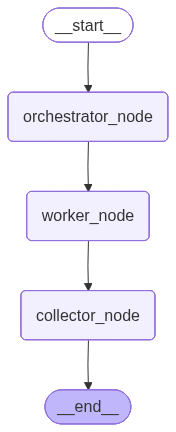

In [ ]:
memory = MemorySaver()

graph = StateGraph(MainState)

graph.add_node("orchestrator_node", orchestrator_node)
graph.add_node("worker_node", worker_node)
graph.add_node("collector_node", collector_node)

graph.add_edge(START, "orchestrator_node")
graph.add_edge("orchestrator_node", "worker_node")
graph.add_edge("worker_node", "collector_node")
graph.add_edge("collector_node", END)

app = graph.compile(checkpointer=memory)
app

In [ ]:
config = {"configurable": {"thread_id": "1"}}

response = app.invoke({
    "user_input": "What are the states of the US and their capitals?",
    "results": [],
    "summary": "",
    "tasks": []
}, config=config)

In [14]:
print(response['summary'])

Here's a concise summary of the results:

**US State List and Capitals**

A list of 50 US states and their capitals has been provided. The list includes:

- **US States**: 50 states in alphabetical order
- **US State Capitals**: 50 state capitals corresponding to the states listed above

**Combining Lists into Data Structures**

Two methods have been demonstrated to combine the lists of US states and their capitals into data structures:

1. **Dictionary**: `us_states_capitals` - A dictionary that maps each state to its corresponding capital, with the state as the key and the capital as the value.
2. **List of Tuples**: `us_states_capitals_list` - A list of tuples where each element is a tuple containing a state and its capital.

Both data structures can be used depending on the specific requirements of the project.


In [ ]:
print(response['tasks'])

print("total tasks")
print(len(response['tasks']))

['Generate a list of US states', 'Create a list of US state capitals', 'Combine the lists of US states and their capitals into a single list']
total tasks
3


In [12]:
for r in response['results']:
    print(r)

Here's a list of 50 US states in alphabetical order:

1. Alabama (AL)
2. Alaska (AK)
3. Arizona (AZ)
4. Arkansas (AR)
5. California (CA)
6. Colorado (CO)
7. Connecticut (CT)
8. Delaware (DE)
9. Florida (FL)
10. Georgia (GA)
11. Hawaii (HI)
12. Idaho (ID)
13. Illinois (IL)
14. Indiana (IN)
15. Iowa (IA)
16. Kansas (KS)
17. Kentucky (KY)
18. Louisiana (LA)
19. Maine (ME)
20. Maryland (MD)
21. Massachusetts (MA)
22. Michigan (MI)
23. Minnesota (MN)
24. Mississippi (MS)
25. Missouri (MO)
26. Montana (MT)
27. Nebraska (NE)
28. Nevada (NV)
29. New Hampshire (NH)
30. New Jersey (NJ)
31. New Mexico (NM)
32. New York (NY)
33. North Carolina (NC)
34. North Dakota (ND)
35. Ohio (OH)
36. Oklahoma (OK)
37. Oregon (OR)
38. Pennsylvania (PA)
39. Rhode Island (RI)
40. South Carolina (SC)
41. South Dakota (SD)
42. Tennessee (TN)
43. Texas (TX)
44. Utah (UT)
45. Vermont (VT)
46. Virginia (VA)
47. Washington (WA)
48. West Virginia (WV)
49. Wisconsin (WI)
50. Wyoming (WY)

Note: Washington D.C. is not a s